In [5]:
!cd ../ && export CUDA_VISIBLE_DEVICES=1 && python main.py --brats --exec_mode predict --task 15 --data /data/private_data/15_3d --dim 3 --fold 0 --nfolds 3 --ckpt_path /results/glioma_results/brain/fold-0/checkpoints/epoch=35-dice_mean=11.94.ckpt --results /results/glioma_infer/fold-0_brats_brain/check --amp --tta --save_preds

Global seed set to 1
0 training, 0 validation, 286 test examples
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Testing:  69%|██████████████████████          | 197/286 [18:11<07:25,  5.01s/it]/opt/conda/lib/python3.8/site-packages/skimage/transform/_warps.py:115: RuntimeWarning: divide by zero encountered in true_divide
  factors = (np.asarray(input_shape, dtype=float) /
Testing: 100%|████████████████████████████████| 286/286 [26:17<00:00,  5.51s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [6]:
! cd /results/glioma_infer/fold-0_brats_brain/check && ls

'predictions_epoch=35-dice_mean=11_94_task=15_fold=0_tta'


In [3]:
! cd /results/glioma_results/brain/fold-0/checkpoints/ && ls

'epoch=0-dice_mean=3.09.ckpt'	 'epoch=54-dice_mean=11.34.ckpt'
'epoch=35-dice_mean=11.94.ckpt'   last.ckpt


1019_18
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


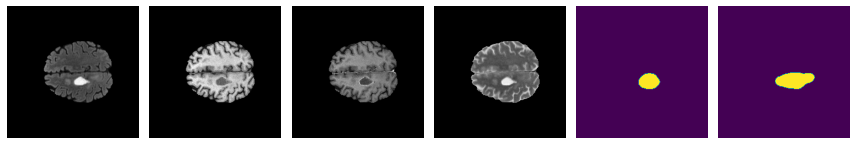

102_19_4
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


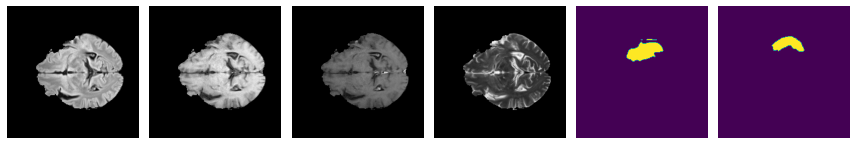

1032_19
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


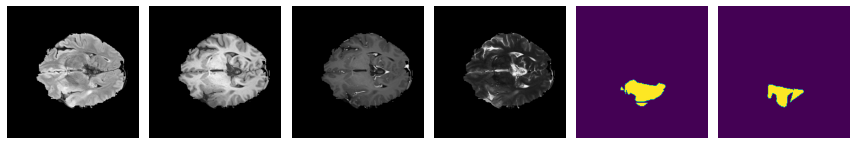

1034_18_4
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


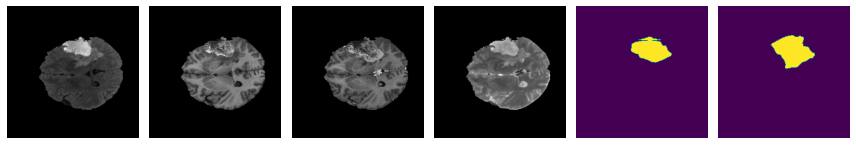

1036_18
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


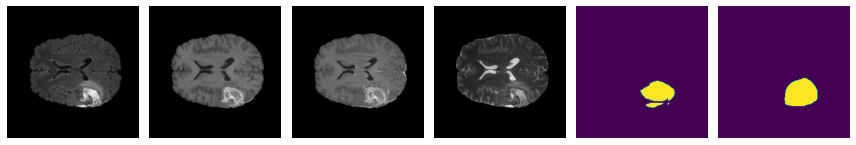

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 110
data = sorted(glob("/results/glioma_infer/fold-0_brats_brain/check/predictions_epoch=35-dice_mean=11_94_task=15_fold=0_tta/*.npy"))
for i, z in zip([0,2,3,4,5,6],[110,65,65,65, 80]):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV_brain/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV_brain/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, z]
    pred = np.load(data[i])
#     pred = to_lbl(np.round(pred, 0))[:, :, z]
    pred = np.round(pred, 0).transpose(3,2,1,0)
    print(label.shape), print(pred.shape)
    print(np.unique(pred)), print(np.unique(label))
    imgs = [img[:, :, z, i] for i in [0, 1, 2, 3]] + [pred[:, :, z, 1]] + [label]    
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 12))
    for i in range(6):
        if i < 4:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [4]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm



def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids', 'Dice_all','Dice_0', 'Dice_1', 'Dice_2', 'Dice_3',
               'Hausdorff95_all', 'Hausdorff95_0', 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_all','Sensitivity_0', 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_all','Specificity_0', 'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_all','Surface_dice_0', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_all', 'Precision_0', 'Precision_1', 'Precision_2', 'Precision_4']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==0), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==0), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==0), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
#     distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
#     df.at[0,'Dice_4'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
#     df.at[0,'Surface_dice_4'] = metrics.compute_surface_dice_at_tolerance(distances,1)
#     df.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
#     sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
#     df.at[0,'Sensitivity_4'] = sens
#     df.at[0,'Precision_4'] = precision
#     df.at[0,'Specificity_4'] = spec
    return df

def get_stats(preds, target, class_idx):
        tp = torch.logical_and(preds == class_idx, target == class_idx).sum()
        fn = torch.logical_and(preds != class_idx, target == class_idx).sum()
        fp = torch.logical_and(preds == class_idx, target != class_idx).sum()
        return tp, fn, fp

    
def compute_stats_brats( p, y):
        scores = torch.zeros(3, device=p.device, dtype=torch.float32)
        p = (torch.sigmoid(p) > 0.5).int()
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        y = torch.stack([y_wt, y_tc, y_et], dim=1)

        for i in range(3):
            p_i, y_i = p[:, i], y[:, i]
            if (y_i != 1).all():
                # no foreground class
                scores[i - 1] += 1 if (p_i != 1).all() else 0
                continue
            tp, fn, fp = get_stats(p_i, y_i, 1)
            denom = (2 * tp + fp + fn).to(torch.float)
            score_cls = (2 * tp).to(torch.float) / denom if torch.is_nonzero(denom) else 0.0
            scores[i - 1] += score_cls
        return scores
    
def calculate_metrics(path_to_pred, path_to_target, spaces = True, name_csv='dice_metrics.csv', path_csv_all = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids', 'Dice_all','Dice_0', 'Dice_1', 'Dice_2', 'Dice_3',
               'Hausdorff95_all', 'Hausdorff95_0', 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_all','Sensitivity_0', 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_all','Specificity_0', 'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_all','Surface_dice_0', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_all', 'Precision_0', 'Precision_1', 'Precision_2', 'Precision_4']
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    label = os.listdir(target_folder)
    label = [l.split('/')[-1][:-11] for l in label]
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-4]
        if sub in label:
            targets = nib.load(target_folder /  f'{sub}_seg.nii.gz').get_fdata()
#         y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
#         targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
        
            predictions = np.load((os.path.join(path_pred, ids)))
            spaces = [1,1,1]
            pred = np.round(predictions, 0)
            pred = np.transpose(pred, (0, 3, 2, 1))
    #         print(targets.shape), print(pred.shape)
    #         print(np.unique(targets)), print(np.unique(pred))
            df=calculate_metrics_brats(targets.astype('int'), pred.astype('int'), sub, spaces)
    #         print(df)
            af_all = af_all.append(df)
        else:
            continue
    af_all.to_csv('all_metris_glioma.csv')  
    print(af_all.mean())

In [7]:
path_pred='/results/glioma_infer/fold-0_brats_brain/check/predictions_epoch=35-dice_mean=11_94_task=15_fold=0_tta'
path_target='/data/private_data/brats_pipeline_out_train_GTV_brain/labels'
calculate_metrics(path_pred, path_target)

100%|██████████| 286/286 [17:21<00:00,  3.64s/it]

Dice_all                  NaN
Dice_0                    NaN
Dice_1               0.503576
Dice_2               0.423588
Dice_3                    NaN
Hausdorff95_all           NaN
Hausdorff95_0             NaN
Hausdorff95_1       58.814546
Hausdorff95_2       41.692387
Hausdorff95_4             NaN
Sensitivity_all           NaN
Sensitivity_0             NaN
Sensitivity_1        0.338543
Sensitivity_2        0.410397
Sensitivity_4             NaN
Specificity_all           NaN
Specificity_0             NaN
Specificity_1        0.597970
Specificity_2        0.997184
Specificity_4             NaN
Surface_dice_all          NaN
Surface_dice_0            NaN
Surface_dice_1       0.090177
Surface_dice_2       0.171273
Surface_dice_4            NaN
Precision_all             NaN
Precision_0               NaN
Precision_1          0.988993
Precision_2          0.512328
Precision_4               NaN
dtype: float64
